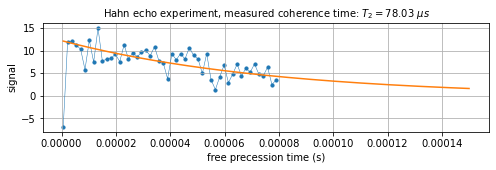

[-1.98634537e-01  1.23919956e+01  7.80308983e-05]


In [3]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

dataPath = 'C:/Users/XQ1/qudi/Data/2024/09/2024-09-23/pulsed_measurement_logic/'
datafileName = '20240923-2306-31_POI_12_Or1_XY8_8_pulsed_measurement.dat'
datafile = open(dataPath + datafileName , 'r')
xData = []
yData = []
for line in datafile.readlines():
    if not line[0] == '#':
        record = line.split()
        xData.append(64*float(record[0]))
        yData.append( float(record[1])-float(record[2]) )
datafile.close()
xData = np.array(xData)
yData = -np.array(yData)
xDataFit = np.append( xData[1:], np.linspace(xData[-1], 1000e-6, 30) )
yDataFit = np.append( yData[1:], np.zeros(30))


p0 = [ 0, np.average(yData[:3]), 30e-6 ]
# period = self.calib_params['rabi_period_HighPower'] if type=='no14N' else self.calib_params['rabi_period_LowPower']
fit_func = lambda t, *p: p[0] + p[1]*np.exp( -t/p[2] )
fitparams, fitparams_covariance = optimize.curve_fit(fit_func, xDataFit, yDataFit, p0=p0, maxfev=10000)

tGrid = np.linspace(xData[0], 150e-6, 1000)
plt.figure(figsize=(8, 2.0))
plt.plot(xData, yData, linewidth=0.5)
plt.scatter(xData, yData, s=10)
plt.plot(tGrid, fit_func(tGrid, *fitparams))
plt.grid()
plt.title(rf'Hahn echo experiment, measured coherence time: $T_2 =${fitparams[2] * 1e6:.2f} $\mu s$', fontsize=10)
plt.ylabel('signal')
plt.xlabel(r'free precession time (s)')
plt.show()

print(fitparams)

In [4]:
import os
import re
from datetime import datetime, timedelta
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def lorentzian_dip(x, offset, center, sig, amp):
    return offset - amp * sig**2 / ((x - center)**2 + sig**2)


def rabi_oscillation(x, offset, amp, freq, phi0):
    return offset + amp * np.cos(2*np.pi*freq*x + np.pi*phi0/180)


def readPulsedMeasurementData(filename):
    with open( filename , 'r') as file:
        data = file.readlines()
    dataList = {}
    for record in data:
        if record[0] != "#":
            numDataCols = len(record.split("\t"))
            for i in range(numDataCols):
                if i not in dataList:
                    dataList[i] = []
                dataList[i].append( float(record.split("\t")[i]) )
    xData = np.array(dataList[0])
    measData = [np.array(dataList[i]) for i in range(1,numDataCols) ]
    return xData, measData


def getRabiFile(currFolder, dayFolder, filename, poi, ornt):
    regexPatternRabi = re.compile(f".*POI_{poi}_.*ornt_{ornt}_.*Rabi.*0.225V_pulsed_measurement.dat")
    folderPreviousDay = currFolder.replace(dayFolder, f'{dayFolder[:-2]}{int(dayFolder[-2:])-1:02d}')
    folderNextDay = currFolder.replace(dayFolder, f'{dayFolder[:-2]}{int(dayFolder[-2:])+1:02d}')
    rabiFiles = []
    for folder in [folderPreviousDay, currFolder, folderNextDay]:
        if os.path.exists(folder):
            for file in os.listdir(folder):
                regex_match = regexPatternRabi.match(file)
                if regex_match:
                    rabiFiles.append( os.path.join(folder, file) )
    refTimeStamp = datetime.strptime(filename[:13] , "%Y%m%d-%H%M")
    rabiFiles.sort()
    for rabiFile in reversed(rabiFiles):
        timeStamp = datetime.strptime( os.path.basename(rabiFile)[:13] , "%Y%m%d-%H%M")
        if abs(timeStamp - refTimeStamp) < timedelta(hours=2):
            return rabiFile


basepath = "C:/Users/XQ1/qudi/Data/2024" 
monthList = [9, 10, 11]

orientation_properties = {
    1: {'res_freq': 2.666e9, 'freq_range': [2630.0e6, 1.4e6, 70],  'rabi_period': 1/12.0e6},
    2: {'res_freq': 2.781e9, 'freq_range': [2730.0e6, 1.0e6, 70],  'rabi_period': 1/10.3e6},
    3: {'res_freq': 2.813e9, 'freq_range': [2790.0e6, 1.0e6, 60], 'rabi_period': 1/5.6e6},
    4: {'res_freq': 2.871e9, 'freq_range': [2840.0e6, 1.0e6, 60], 'rabi_period': 1/9.9e6},
}

regexPatternOdmr = re.compile(".*POI_([0-9]+)_.*ornt_([0-9])_.*PODMR.*0.225V_pulsed_measurement.dat")

extractedData = []

for month in monthList:
    for dayFolder in os.listdir( os.path.join(basepath, f'{month:02d}') ):
        currFolder = os.path.join(basepath, f'{month:02d}', dayFolder, 'pulsed_measurement_logic')
        if os.path.exists( currFolder ):
            for filename in os.listdir(currFolder):
                regex_match = regexPatternOdmr.match(filename)
                if regex_match:
                    poi = regex_match.group(1)
                    ornt = int(regex_match.group(2))
                    extractedData.append( {"POI": poi, "orientation": ornt} )
                    fData, signal = readPulsedMeasurementData( os.path.join(currFolder, filename) )
                    signal = signal[0]
                    p0 = [ np.average(signal), orientation_properties[ornt]['res_freq'], 5e6, (signal.max()-signal.min())]
                    params, params_covariance = optimize.curve_fit(lorentzian_dip, fData, signal, p0=p0, maxfev=int(5e4))
                    mse = np.sqrt( np.mean((signal - lorentzian_dip(fData, *params))**2) )
                    odmrContrast = abs(params[3])/params[0]*100

                    if (params[3] < 0) or (mse/params[3]*100 > 50) or (odmrContrast < 1.5):
                        extractedData[-1]['present'] = False
                    else:
                        rabiFile = getRabiFile(currFolder, dayFolder, filename, poi, ornt)
                        if rabiFile:
                            tData, rabiSignal = readPulsedMeasurementData( rabiFile )
                            rabiSignal = rabiSignal[0]
                            for freqFactor in [1, 0.7, 1.2]:
                                p0 = [ np.average(rabiSignal), (rabiSignal.max()-rabiSignal.min()), freqFactor/orientation_properties[ornt]['rabi_period'], 0 ]
                                rabiParams, params_covariance = optimize.curve_fit(rabi_oscillation, tData, rabiSignal, p0=p0, maxfev=int(5e4))
                                rabiMse = np.sqrt( np.mean((rabiSignal - rabi_oscillation(tData, *rabiParams))**2) )
                                rabiFitDeviation = rabiMse/abs(2*rabiParams[1])*100
                                rabiContrast = 2*abs(rabiParams[1])/rabiParams[0]*100
                                if rabiFitDeviation < 50:
                                    break
                            if (rabiFitDeviation >= 50) or (rabiContrast < 1.5) or (rabiParams[2]*orientation_properties[ornt]['rabi_period'] < 0.3):
                                extractedData[-1]['present'] = False
                            else:
                                extractedData[-1]['present'] = True
                                extractedData[-1]['odmrContrast'] = odmrContrast
                                extractedData[-1]['deltaRes'] = abs(orientation_properties[ornt]["res_freq"]-params[1])
                                extractedData[-1]['rabiContrast'] = rabiContrast
                                extractedData[-1]['rabiPeriod'] = 1/rabiParams[2]
                                # print( (f'POI: {poi}, ornt: {ornt}, ODMR fit deviation: {mse/params[3]*100:2f}, ' + 
                                #         f'deviation from reference resonance: {abs(orientation_properties[ornt]["res_freq"]-params[1])*1e-6:.1f} MHz, ' + 
                                #         f'ODMR contrast: {odmrContrast:.1f}%, Rabi contrast: {rabiContrast:.1f}%, ' +
                                #         f'Rabi fit deviation: {rabiFitDeviation:.1f}, Rabi period: {1/rabiParams[2]*1e9:.0f}ns' ) )
                        # if poi=='58':
                        #     fGrid = np.linspace(fData[0], fData[-1], 1000)
                        #     plt.scatter( fData, signal )
                        #     plt.plot( fGrid, lorentzian_dip(fGrid, *params) )
                        #     plt.show()
                        #     tGrid = np.linspace(tData[0], tData[-1], 1000)
                        #     plt.scatter( tData, rabiSignal )
                        #     plt.plot( tGrid, rabi_oscillation(tGrid, *rabiParams) )
                        #     plt.show()

df = pd.DataFrame.from_dict(extractedData)
df.to_csv('POI_characterization_table.csv', index=False)